<a href="https://colab.research.google.com/github/vinbaskaran/AI_projects/blob/main/HelpMate_AI_Live_Session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agenda for the live session

- Quick Introduction (~5 minutes)
- Recap of RAG (~10 minutes)
- Problem Statement Discussion (~10 minutes)
- System Design Discussion (~30 minutes)
- Code Explanation (~20 minutes)
- Doubt Resolution (~20 minutes)

In [ ]:
# Install the following packages incase they're not loaded already
!pip install pdfplumber
!pip install chromadb
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 499.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 485.3 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 48.8 MB/s eta 0:0

In [ ]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
import openai

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/HelpMate_AI_Support_Session/"


In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

## Quick Recap of RAG

Quick Recap of a RAG system

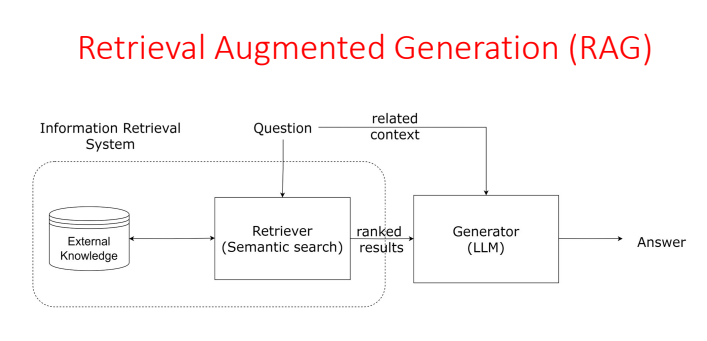

In [ ]:
## Issues with normal LLMs
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":"What is the revenue of uber in 2021?"},
          ]

In [ ]:
## New method (as older completion and chatcompletion endpoints have been deprecated)
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"I am not able to provide real-time information as I do not have access to the internet. I recommend checking the latest financial reports or news articles to get the most up-to-date information on Uber's revenue in 2021."

As you see the LLMs may not have access to your internal data, and therefore, they won't be able to **retrieve** information beyond the data that they have been trained on

However there's a trick you can use!!

Here's the relevant snippet from uber's annual filings report uber_2021. pdf page 53

*Revenue was $17.5 billion, or up 57% year-over-year, reflecting the overall growth in our Delivery business and an increase in Freight revenue attributable tothe acquisition of Transplace in the fourth quarter of 2021 as well as growth in the number of shippers and carriers on the network combined with an increase involumes with our top shippers.*

In [ ]:
retrieved = "Revenue was $17.5 billion, or up 57% year-over-year, reflecting the overall growth in our Delivery business and an increase in Freight revenue attributable tothe acquisition of Transplace in the fourth quarter of 2021 as well as growth in the number of shippers and carriers on the network combined with an increase involumes with our top shippers."

In [ ]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2021?. Use the information presented in '{retrieved}' """},
          ]

In [ ]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'The revenue of Uber in 2021 was $17.5 billion.'

So what we did above was,
- We **retrieved** the information from an external source,
- **Augmented** our query with the relevant information prompt,
- and finally we **generated** the relevant response

This above process is RAG in a nutshell!

## Starter Code explanation

### Data Processing

Quite crucial, hence suggested to use good parsers that can load the data from your documents effectively.


In [ ]:
pdf_path = "/content/drive/MyDrive/HelpMate_AI_Support_Session/data"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [ ]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing uber_2021 (1).pdf
Finished processing uber_2021 (1).pdf
All PDFs have been processed.


In [ ]:
finance_pdfs_data = pd.concat(data, ignore_index=True)

In [ ]:
finance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...,uber_2021 (1).pdf
1,Page 2,Large accelerated filer ☒ Accelerated filer ☐ ...,uber_2021 (1).pdf
2,Page 3,"UBER TECHNOLOGIES, INC. TABLE OF CONTENTS Page...",uber_2021 (1).pdf
3,Page 4,SPECIAL NOTE REGARDING FORWARD-LOOKING STATEME...,uber_2021 (1).pdf
4,Page 5,looking statements as predictions of future ev...,uber_2021 (1).pdf


In [ ]:
len(finance_pdfs_data)

307

In [ ]:
finance_pdfs_data['Metadata'] = finance_pdfs_data.apply(lambda x: {'filing_name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [ ]:
finance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name,Metadata
0,Page 1,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...,uber_2021 (1).pdf,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '..."
1,Page 2,Large accelerated filer ☒ Accelerated filer ☐ ...,uber_2021 (1).pdf,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '..."
2,Page 3,"UBER TECHNOLOGIES, INC. TABLE OF CONTENTS Page...",uber_2021 (1).pdf,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '..."
3,Page 4,SPECIAL NOTE REGARDING FORWARD-LOOKING STATEME...,uber_2021 (1).pdf,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '..."
4,Page 5,looking statements as predictions of future ev...,uber_2021 (1).pdf,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '..."


## Generate and Store Embeddings using OpenAI and ChromaDB
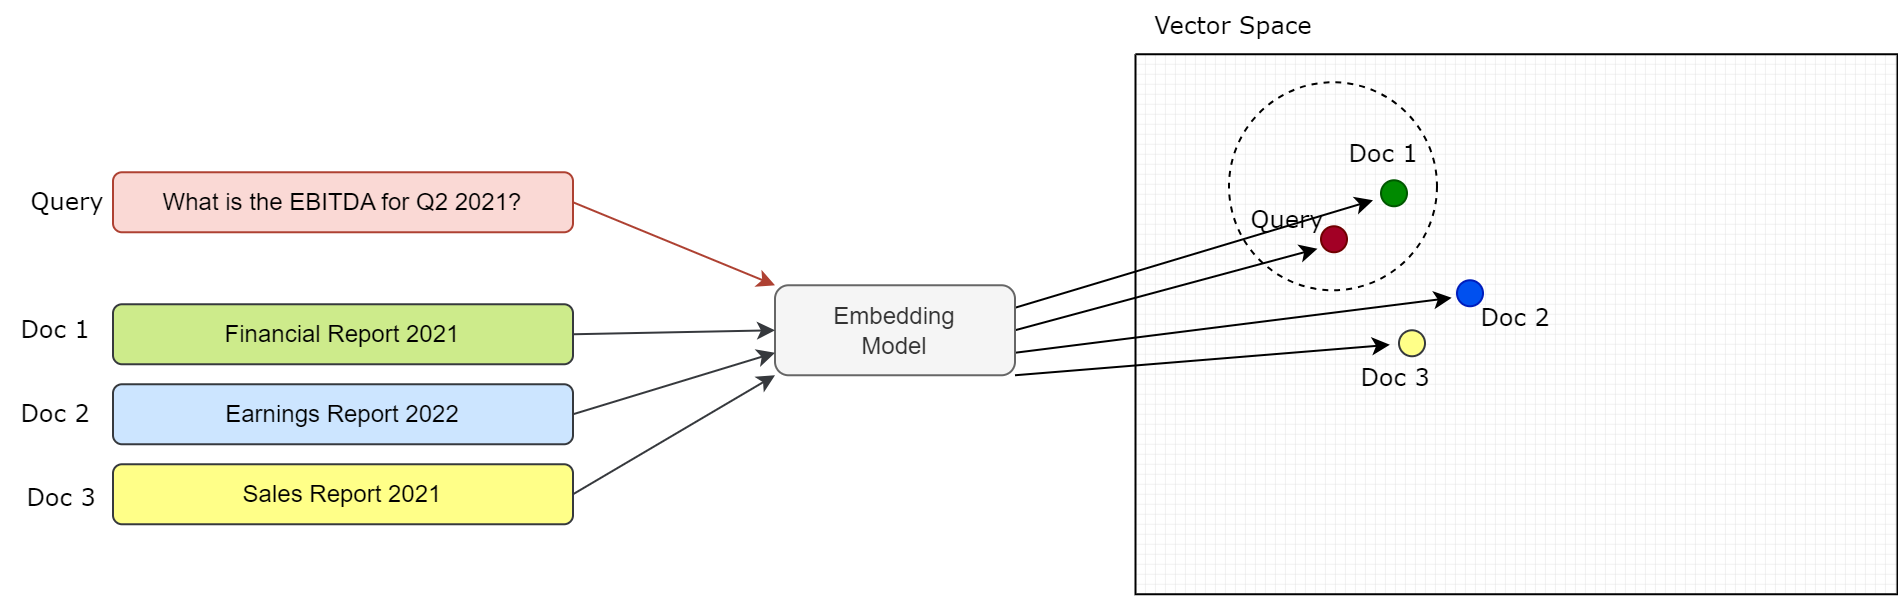

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = "/content/drive/MyDrive/HelpMate_AI_Support_Session/ChromaDB_Data"

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
## Create an empty collection
financedata_collection = client.get_or_create_collection(name='RAG_on_Uber', embedding_function=embedding_function)

In [ ]:
documents_list = finance_pdfs_data["Page_Text"].tolist()
metadata_list = finance_pdfs_data['Metadata'].tolist()

In [ ]:
documents_list

['UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 ____________________________________________ FORM 10-K ____________________________________________ (Mark One) ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended December 31, 2021 OR ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the transition period from_____ to _____ Commission File Number: 001-38902 ____________________________________________ UBER TECHNOLOGIES, INC. (Exact name of registrant as specified in its charter) ____________________________________________ Delaware 45-2647441 (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.) 1515 3rd Street San Francisco, California 94158 (Address of principal executive offices, including zip code) (415) 612-8582 (Registrant’s telephone number, including area code) ____________________________________________ 

In [ ]:
?financedata_collection.add

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.



# financedata_collection.add(
#     documents= documents_list,
#     ids = [str(i) for i in range(0, len(documents_list))],
#     metadatas = metadata_list
# )

# Define batch size based on token estimate (you may adjust this)
batch_size = 100  # or 50 if docs are long

for i in range(0, len(documents_list), batch_size):
    batch_docs = documents_list[i:i+batch_size]
    batch_ids = [str(j) for j in range(i, i+len(batch_docs))]
    batch_meta = metadata_list[i:i+batch_size]

    financedata_collection.add(
        documents=batch_docs,
        ids=batch_ids,
        metadatas=batch_meta
    )


In [ ]:
financedata_collection.peek(1)

{'ids': ['0'],
 'embeddings': array([[ 0.00557413, -0.03556351,  0.01102944, ..., -0.0020049 ,
          0.00498998, -0.00978855]]),
 'documents': ['UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 ____________________________________________ FORM 10-K ____________________________________________ (Mark One) ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended December 31, 2021 OR ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the transition period from_____ to _____ Commission File Number: 001-38902 ____________________________________________ UBER TECHNOLOGIES, INC. (Exact name of registrant as specified in its charter) ____________________________________________ Delaware 45-2647441 (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.) 1515 3rd Street San Francisco, California 94158 (Address of principal execu

In [ ]:
# Let's take a look at the first few entries in the collection

financedata_collection.get(
   ids = ['0','1','2'],
   include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[ 0.00557413, -0.03556351,  0.01102944, ..., -0.0020049 ,
          0.00498998, -0.00978855],
        [-0.02048277, -0.02791148, -0.00631507, ..., -0.00023698,
          0.00077635, -0.02134407],
        [-0.00234099, -0.02717387, -0.00080123, ..., -0.01316726,
          0.0020082 ,  0.00375083]]),
 'documents': ['UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 ____________________________________________ FORM 10-K ____________________________________________ (Mark One) ☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the fiscal year ended December 31, 2021 OR ☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the transition period from_____ to _____ Commission File Number: 001-38902 ____________________________________________ UBER TECHNOLOGIES, INC. (Exact name of registrant as specified in its charter) __________________________

In [ ]:
cache_collection = client.get_or_create_collection(name='Finance2_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': []}

## Semantic Search with Cache

We have created 2 collections
- financedata_collection (embeddings are already present)
- cache_collection (an empty collection at the beginning)

Our strategy is to first check the cache_collection and see if can answer the query or not.

In case it doesn't the query then passes to the financedata_collection, and the query results get appended to cache_collection (embeddings, metadata, etc)

Semantic Search Pipeline

In [ ]:
# Read the user query
query = input()

What is uber's revenue in 2021


In [ ]:
query

"What is uber's revenue in 2021"

In [ ]:
## Let's query the above result
?financedata_collection.query

In [ ]:
## Quickly checking the results of the query
results = financedata_collection.query(
      query_texts=query,
      n_results=10
      )

In [ ]:
results

{'ids': [['52', '56', '97', '76', '128', '83', '59', '64', '75', '24']],
 'embeddings': None,
 'documents': [['Financial and Operational Highlights Year Ended December 31, Constant Currency (1) [[null, null, null, null, null, null, null, null, null, null, null, "2020 to 2021 % Change", null], ["Monthly Active Platform Consumers (\\u201cMAPCs\\u201d) (2), (3)", "", "93", null, "", "118", null, "", "27", "%", "", "", null], ["Trips (2)", "", "5,025", null, "", "6,368", null, "", "27", "%", "", "", null], ["Gross Bookings (2)", "", "$", "57,897", "", "$", "90,415", "", "56", "%", "", "53", "%"], [null, "", "$", "11,139", "", "$", "17,455", "", "57", "%", "", "54", "%"], ["Net loss attributable to Uber Technologies, Inc. (4)", "", "$", "(6,768)", "", "$", "(496)", "", "93", "%", "", "", null], ["Mobility Adjusted EBITDA", "", "$", "1,169", "", "$", "1,596", "", "37", "%", "", "", null], ["Delivery Adjusted EBITDA", "", "$", "(873)", "", "$", "(348)", "", "60", "%", "", "", null], ["Adjuste

In [ ]:
for key, val in results.items():
  print(key)

ids
embeddings
documents
uris
included
data
metadatas
distances


In [ ]:
for key, val in results.items():
  print(val)

[['52', '56', '97', '76', '128', '83', '59', '64', '75', '24']]
None
[['Financial and Operational Highlights Year Ended December 31, Constant Currency (1) [[null, null, null, null, null, null, null, null, null, null, null, "2020 to 2021 % Change", null], ["Monthly Active Platform Consumers (\\u201cMAPCs\\u201d) (2), (3)", "", "93", null, "", "118", null, "", "27", "%", "", "", null], ["Trips (2)", "", "5,025", null, "", "6,368", null, "", "27", "%", "", "", null], ["Gross Bookings (2)", "", "$", "57,897", "", "$", "90,415", "", "56", "%", "", "53", "%"], [null, "", "$", "11,139", "", "$", "17,455", "", "57", "%", "", "54", "%"], ["Net loss attributable to Uber Technologies, Inc. (4)", "", "$", "(6,768)", "", "$", "(496)", "", "93", "%", "", "", null], ["Mobility Adjusted EBITDA", "", "$", "1,169", "", "$", "1,596", "", "37", "%", "", "", null], ["Delivery Adjusted EBITDA", "", "$", "(873)", "", "$", "(348)", "", "60", "%", "", "", null], ["Adjusted EBITDA (1), (2)", "", "$", "(2,528)",

Building the cache

In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top result

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[]],
 'distances': [[]]}

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = financedata_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      # for key, val in results.items():
      #   if key not in ['embeddings', 'uris','data']:
      #     for i in range(10):
      #       Keys.append(str(key)+str(i))
      #       Values.append(str(val[0][i]))

      for key, val in results.items():
        if key not in ['embeddings', 'uris', 'data']:
            if isinstance(val[0], list):  # Expected case
                for i in range(len(val[0])):
                    Keys.append(f"{key}{i}")
                    Values.append(str(val[0][i]))
            else:
                # Handle non-list values safely
                Keys.append(f"{key}0")
                Values.append(str(val[0]))



      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Not found in cache. Found in main collection.


In [ ]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 53', 'filing_name': 'uber_2...",Financial and Operational Highlights Year Ende...,0.264787,52
1,"{'Page_No.': 'Page 57', 'filing_name': 'uber_2...",The following table sets forth the components ...,0.276280,56
2,"{'Page_No.': 'Page 98', 'filing_name': 'uber_2...",Note 2 – Revenue The following tables present ...,0.284981,97
3,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...","UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...",0.289503,76
4,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...","Year Ended December 31, 2019 2020 2021 [[""Unit...",0.317514,128
5,"{'Page_No.': 'Page 84', 'filing_name': 'uber_2...","UBER TECHNOLOGIES, INC. NOTES TO CONSOLIDATED ...",0.331156,83
6,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...",Provision for (Benefit from) Income Taxes Year...,0.341654,59
7,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...",The following table presents a reconciliation ...,0.343224,64
8,"{'Page_No.': 'Page 76', 'filing_name': 'uber_2...","UBER TECHNOLOGIES, INC. CONSOLIDATED BALANCE S...",0.344479,75
9,"{'Page_No.': 'Page 25', 'filing_name': 'uber_2...",Our operating results may vary significantly a...,0.348484,24


In [ ]:
## Checking if the cache also contains the results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

{'ids': [["What is uber's revenue in 2021"]],
 'embeddings': None,
 'documents': [["What is uber's revenue in 2021"]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'metadatas8': "{'Page_No.': 'Page 76', 'filing_name': 'uber_2021 (1)'}",
    'documents2': 'Note 2 – Revenue The following tables present our revenues disaggregated by offering and geographical region. Revenue by geographical region is based on where the transaction occurred. This level of disaggregation takes into consideration how the nature, amount, timing, and uncertainty of revenue and cash flows are affected by economic factors. Revenue is presented in the following tables for the years ended December 31, 2019, 2020 and 2021, respectively (in millions): Year Ended December 31, 2019 2020 2021 [["Mobility revenue (1)", "", "$", "10,707", "", "$", "6,089", "", "$", "6,953"], ["Delivery revenue (1)", "", "1,401", null, "", "3,904", null, "", "8,362", null], ["Freight 

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

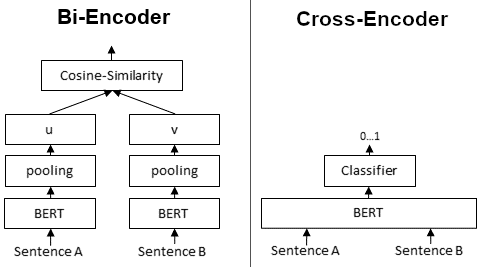

<br>

In [ ]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['What is the revenue of uber in 2021', 'The revenue of uber in 2021 was $17 billion'],
                                ['What is the revenue of uber in 2021', 'The revenue of uber in 2021 is good. The revenue of uber is great. The revenue of uber showed great promise']])

In [ ]:
scores

array([10.59103  ,  8.7543745], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
 #Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 53', 'filing_name': 'uber_2...",Financial and Operational Highlights Year Ende...,0.264787,52,-3.563679
1,"{'Page_No.': 'Page 57', 'filing_name': 'uber_2...",The following table sets forth the components ...,0.276280,56,-2.421250
2,"{'Page_No.': 'Page 98', 'filing_name': 'uber_2...",Note 2 – Revenue The following tables present ...,0.284981,97,4.726566
3,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...","UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...",0.289503,76,5.092112
4,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...","Year Ended December 31, 2019 2020 2021 [[""Unit...",0.317514,128,-2.888365
5,"{'Page_No.': 'Page 84', 'filing_name': 'uber_2...","UBER TECHNOLOGIES, INC. NOTES TO CONSOLIDATED ...",0.331156,83,-2.698602
6,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...",Provision for (Benefit from) Income Taxes Year...,0.341654,59,-4.664515
7,"{'filing_name': 'uber_2021 (1)', 'Page_No.': '...",The following table presents a reconciliation ...,0.343224,64,1.087331
8,"{'Page_No.': 'Page 76', 'filing_name': 'uber_2...","UBER TECHNOLOGIES, INC. CONSOLIDATED BALANCE S...",0.344479,75,1.634782
9,"{'Page_No.': 'Page 25', 'filing_name': 'uber_2...",Our operating results may vary significantly a...,0.348484,24,-3.719431


In [ ]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 53', 'filing_name': 'uber_2...",Financial and Operational Highlights Year Ende...,0.264787,52,-3.563679
1,"{'Page_No.': 'Page 57', 'filing_name': 'uber_2...",The following table sets forth the components ...,0.276280,56,-2.421250
2,"{'Page_No.': 'Page 98', 'filing_name': 'uber_2...",Note 2 – Revenue The following tables present ...,0.284981,97,4.726566


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

,Documents,Metadatas
3,"UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...","{'filing_name': 'uber_2021 (1)', 'Page_No.': '..."
2,Note 2 – Revenue The following tables present ...,"{'Page_No.': 'Page 98', 'filing_name': 'uber_2..."
8,"UBER TECHNOLOGIES, INC. CONSOLIDATED BALANCE S...","{'Page_No.': 'Page 76', 'filing_name': 'uber_2..."


## Build the RAG system

In [ ]:
retrieved = top_3_RAG[["Documents", "Metadatas"]][:3]



In [ ]:
# retrieved = # Just the text from 'Documents' column
retrieved_text = "\n\n".join(top_3_RAG['Documents'].tolist())


In [ ]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2021?. You are provided the filing report of 2021 in'{retrieved_text}' """},
          ]

In [ ]:
messages

[{'role': 'system', 'content': 'You are an AI assistant to user.'},
 {'role': 'user',
  'content': 'What is the revenue of uber in 2021?. You are provided the filing report of 2021 in\'UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENTS OF OPERATIONS (In millions, except share amounts which are reflected in thousands, and per share amounts) Year Ended December 31, 2019 2020 2021 [["Revenue", "", "$", "13,000", "", "$", "11,139", "", "$", "17,455"], ["Costs and expenses", "", "", null, "", "", null, "", "", null], ["Cost of revenue, exclusive of depreciation and amortization shown separately below", "", "6,061", null, "", "5,154", null, "", "9,351", null], ["Operations and support", "", "2,302", null, "", "1,819", null, "", "1,877", null], ["Sales and marketing", "", "4,626", null, "", "3,583", null, "", "4,789", null], ["Research and development", "", "4,836", null, "", "2,205", null, "", "2,054", null], ["General and administrative", "", "3,299", null, "", "2,666", null, "", "2,316", null

In [ ]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'The revenue of Uber in 2021 was $17,455 million. This information is based on the provided filing report for the year ended December 31, 2021.'

Next steps for you

- The above prompt is a very simplistic one. Build a robust prompt template that can give you the search results, along with citations (Page No, metadata, etc)

- Test out the prompt results thoroughly,
- Modularize the different parts from semantic search section onwards. There can be better and more systematic pipelines.